In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from tpot import TPOTRegressor

Dataset Loaded:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23     452600.0  
1    -122.22     358500.0  
2    -122.24     352100.0  
3    -122.25     341300.0  
4    -122.25     342200.0  

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    2064

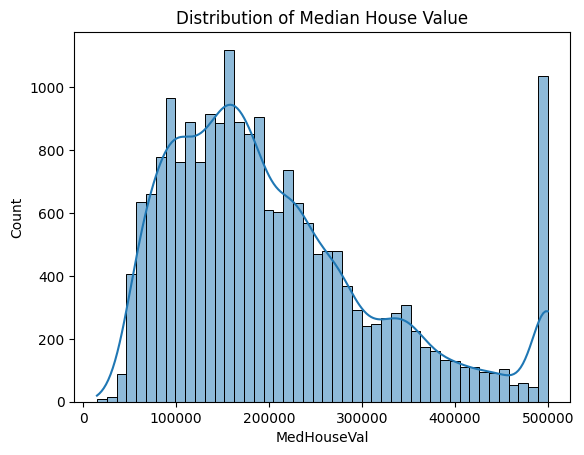

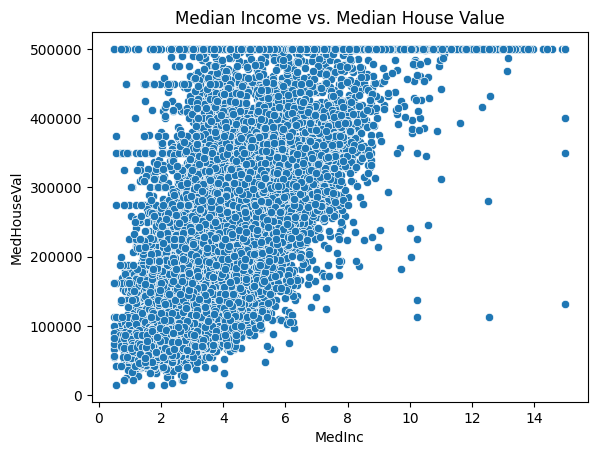

In [2]:
data = fetch_california_housing(as_frame=True)
df = data.frame
df['MedHouseVal'] = df['MedHouseVal'] * 100000  # Scale up target for better readability

print("Dataset Loaded:")
print(df.head())
print("\nData Information:")
print(df.info())
print("\nData Description:")
print(df.describe())

sns.histplot(df['MedHouseVal'], kde=True)
plt.title('Distribution of Median House Value')
plt.show()

sns.scatterplot(data=df, x='MedInc', y='MedHouseVal')
plt.title('Median Income vs. Median House Value')
plt.show()

In [3]:
imputer = SimpleImputer(strategy='median')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

scaler = StandardScaler()
df[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']] = scaler.fit_transform(
    df[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']]
)

In [4]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['Latitude', 'Longitude']])

iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = iso_forest.fit_predict(df[['MedHouseVal', 'MedInc', 'Latitude', 'Longitude']])

df['RoomsPerHousehold'] = df['AveRooms'] / df['AveOccup']

In [5]:
target = 'MedHouseVal'
X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tpot = TPOTRegressor(verbosity=2, generations=5, population_size=20, random_state=42)
tpot.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2551197090.3287787

Generation 2 - Current best internal CV score: -2529195810.984186

Generation 3 - Current best internal CV score: -2489570461.741132

Generation 4 - Current best internal CV score: -2389445781.3221893

Generation 5 - Current best internal CV score: -2298142934.6493196

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.4, min_samples_leaf=2, min_samples_split=6, n_estimators=100)


TPOTRegressor(generations=5, population_size=20, random_state=42, verbosity=2)

In [6]:
print("\nModel Training Completed!")
print("Best model evaluation on test set:")
print(tpot.score(X_test, y_test))

tpot.export('best_model_pipeline.py')


Model Training Completed!
Best model evaluation on test set:
-2240040952.834394
